In [1]:
import os
import uuid
import numpy as np
import cv2
import time
import albumentations as a
import tensorflow as tf
 
import pybboxes as pbx

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [3]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Metal device set to: Apple M1


2022-06-30 14:36:31.174749: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-30 14:36:31.175560: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


True

In [4]:
images = tf.data.Dataset.list_files('data-nosplit/train/images/*.jpg',shuffle = True)

2022-06-30 14:36:32.101232: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-30 14:36:32.101273: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
images.as_numpy_iterator().next()

b'data-nosplit/train/images/162_jpg.rf.e584ee539c10fe9e046421b3c471f56c.jpg'

In [6]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [7]:
images = images.map(load_image)

In [8]:
transform = a.Compose([
    a.RandomCrop(width = 400,height = 400),
    a.HorizontalFlip(p=0.6),
    a.RandomBrightnessContrast(p=0.2),
    a.RandomGamma(p=0.2),
    a.RGBShift(p=0.2),
    a.VerticalFlip(p=0.5)
],
    bbox_params = a.BboxParams(format = "yolo",min_area = 2500,label_fields = ['class_labels'])
)

In [9]:
def yolo_cords_to_voc(coords,h,w):
    return pbx.convert_bbox(coords,from_type = "yolo", to_type = "voc",image_size = (h,w))

In [10]:
img = cv2.imread(os.path.join('data','train','images','133_jpg.rf.8c8e0a9b1a794ac78f80c84dbe7b840d.jpg'))

In [11]:
label_path = os.path.join('data','train','labels','133_jpg.rf.8c8e0a9b1a794ac78f80c84dbe7b840d.txt')

In [12]:
label_file = open(label_path,"r")
label = label_file.readlines()

In [13]:
coords = label[0].split()[1:]

In [14]:
for i in range(len(coords)):
    coords[i] = float(coords[i])

In [15]:
augmented = transform(image = img,bboxes = [coords], class_labels = ['0'])

In [16]:
coords = augmented['bboxes'][0]

In [17]:
coords = yolo_cords_to_voc(coords,400,400)

In [18]:
w,h,c = augmented['image'].shape

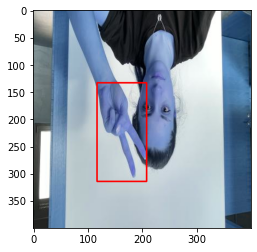

In [19]:
cv2.rectangle(augmented['image'],coords[:2],coords[2:],
              (255,0,0),2)
plt.imshow(augmented['image'])
              

In [20]:
def str_int_coords(cr):
    for i in range(len(cr)):
        cr[i] = float(cr[i])
    return cr

In [21]:
def int_to_str(cr):
    res = ''
    for i,el in enumerate(cr):
        if(i!=0):
            res = res+' '
        
        res = res+  str(cr[i])
    return res

In [22]:
for partition in ['train','test','valid']:
    for image in os.listdir(os.path.join('data',partition,'images')):
        img_path  = os.path.join('data',partition,'images',image)
        img = cv2.imread(img_path)
        coords = []
        
        img_name = os.path.splitext(img_path)[0]
        img_name = img_name.split('/')[-1]
        
        label_path = img_name+'.txt' 
        label_path = os.path.join('data',partition,'labels',label_path)
        class_labels = []
        coords_boxes=[]
    
        
        if os.path.exists(label_path):
            with open(label_path) as f:
                labels = f.readlines()
                
                for line in labels:
                    class_labels.append(str(1))
                    coords = line[1:].split()
                    coords = str_int_coords(coords)
                    coords_boxes.append(coords)
                    
        try:
            for x in range(60):
                
                augmented = transform(image = img, bboxes = coords_boxes,class_labels = class_labels)
                img_name = os.path.splitext(img_path)[0]
                img_name = img_name.split('/')[-1]
                aug_img_path = img_name + '.' + str(x)+'.jpg' 
                aug_img_path = os.path.join('aug_data',partition,'images',aug_img_path)
                
                aug_label_path = img_name + '.' + str(x) + '.txt'
                aug_label_path = os.path.join('aug_data',partition,'labels',aug_label_path)
                
                
                
                cv2.imwrite(aug_img_path,augmented['image'])
                
                if os.path.exists(label_path):
                    
                    if len(augmented['bboxes'])==0:
                        file = open(aug_label_path,"w")
                        file.close()
                    else:
                        file = open(aug_label_path,"w")
                        for idx,line in enumerate(augmented['bboxes']):
                            
                            #stringw = str(augmented['class_labels'][idx]+1)
                            stringw = str(1)
                            linew = int_to_str(line)
                            wr = stringw+' '+linew+'\n'
                            file.write(wr)
                        file.close()
                
                            
                            
                            
                            
                    
            
        except Exception as e:
            print(e)
                
                
            
            

image must be numpy array type


In [23]:
img = cv2.imread(os.path.join('aug_data','train','images','137_jpg.rf.af8fc6c6f7c84082549f38d5e0b3fdf5.13.jpg'))

In [24]:
label_path = os.path.join('aug_data','train','labels','137_jpg.rf.af8fc6c6f7c84082549f38d5e0b3fdf5.13.txt')

In [25]:
label_file = open(label_path,"r")
label = label_file.readlines()
coords1= []
coords2 = []
if len(label)>0:
    coords1 = label[0].split()[1:]
    for i in range(len(coords1)):
        coords1[i] = float(coords1[i])
if len(label)>1:
    coords2 = label[1].split()[1:]
    for i in range(len(coords2)):
        coords2[i] = float(coords2[i])

In [26]:
img.shape

(400, 400, 3)

In [27]:
coords1

[0.5149999999999999, 0.57375, 0.21375, 0.48000000000000004]

In [28]:
coords2

[]

In [29]:


s1 = len(coords1)
s2 = len(coords2)

In [30]:
if s1>0: coords1 = tuple(coords1)
if s2>0: coords2 = tuple(coords2)

In [31]:
if s1>0: coords1 =  yolo_cords_to_voc(coords1,img.shape[0],img.shape[1])
if s2>0: coords2 =  yolo_cords_to_voc(coords2,img.shape[0],img.shape[1])

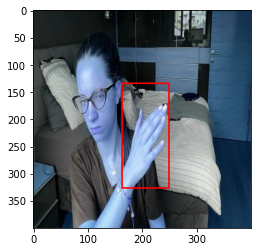

In [32]:
if s1>0:cv2.rectangle(img,coords1[:2],coords1[2:],
              (255,0,0),2)
if s2>0:cv2.rectangle(img,coords2[:2],coords2[2:],
              (255,0,0),2)
plt.imshow(img)

In [33]:
train_images = tf.data.Dataset.list_files('aug_data/train/images/*.jpg',shuffle = False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x,(120,120)))
train_images = train_images.map(lambda x: x/255)

test_images = tf.data.Dataset.list_files('aug_data/test/images/*.jpg',shuffle = False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x,(120,120)))
test_images = test_images.map(lambda x: x/255)

val_images = tf.data.Dataset.list_files('aug_data/valid/images/*.jpg',shuffle = False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x,(120,120)))
val_images = val_images.map(lambda x: x/255)

In [34]:
def load_labels(label_path):
    
    class_labels = []
    coords_boxes=tf.zeros([0, 4])
    coords_list = []
    
    with open(label_path.numpy(),'r',encoding = "utf-8") as f:
        labels = f.readlines()
        for line in labels:
            class_labels.append(int(line[0]))
            coords = line[1:].split()
            coords = str_int_coords(coords)
            coords_list.append(coords)
            
    if len(coords_list) ==0:
        class_labels.append(0)
        coords_list.append([0,0,0,0])
        class_labels.append(0)
        coords_list.append([0,0,0,0])
        
    elif len(coords_list)==1:
        class_labels.append(0)
        coords_list.append([0,0,0,0])
   
    coords_boxes = tf.concat([coords_boxes,coords_list],axis = 0)
            
    return class_labels,coords_boxes

In [36]:
train_labels = tf.data.Dataset.list_files('aug_data/train/labels/*.txt',shuffle = False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels,[x],[tf.uint8,tf.float32]))

In [37]:
test_labels = tf.data.Dataset.list_files('aug_data/test/labels/*.txt',shuffle = False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels,[x],[tf.uint8,tf.float32]))

In [38]:
val_labels = tf.data.Dataset.list_files('aug_data/valid/labels/*.txt',shuffle = False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels,[x],[tf.uint8,tf.float32]))

In [39]:
val_labels.as_numpy_iterator().next()

2022-06-30 14:37:39.276214: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


(array([1, 1], dtype=uint8),
 array([[0.3975 , 0.455  , 0.11125, 0.31   ],
        [0.73125, 0.6825 , 0.12   , 0.2875 ]], dtype=float32))

In [40]:
len(train_images),len(train_labels),len(val_images),len(val_labels),len(test_images),len(test_labels)

(2940, 2940, 780, 780, 180, 180)

In [41]:
train = tf.data.Dataset.zip((train_images,train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [42]:
val = tf.data.Dataset.zip((val_images,val_labels))
val = val.shuffle(5000)
val = val.batch(8)
val = val.prefetch(4)

In [43]:
test = tf.data.Dataset.zip((test_images,test_labels))
test = test.shuffle(5000)
test = test.batch(8)
test = test.prefetch(4)

In [44]:
train.as_numpy_iterator().next()[0].shape

(8, 120, 120, 3)

In [45]:
data_samples = test.as_numpy_iterator()

In [46]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


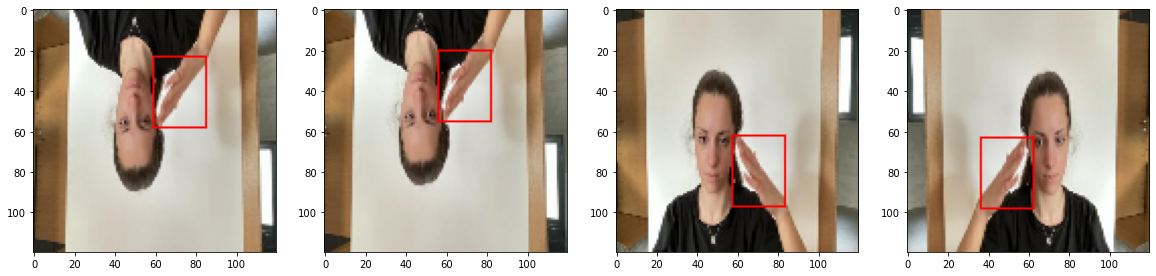

In [47]:
fig,ax = plt.subplots(ncols = 4,figsize = (20,20))
for idx in range(4):
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    classes = res[1][0][idx]
    first = sample_coords[0,:]
    second = sample_coords[1,:]
    
    if classes[0]==1:
        print_first = yolo_cords_to_voc(first,120,120)
        cv2.rectangle(sample_image,print_first[:2],print_first[2:],(255,0,0),1)
    if classes[1]==1:
        print_second = yolo_cords_to_voc(second,120,120)
        cv2.rectangle(sample_image,print_second[:2],print_second[2:],(255,0,0),1)
    
    
   
    
    ax[idx].imshow(sample_image)
    
    
                 
    

In [48]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,Dense,Flatten,Add,GlobalMaxPooling2D,Dropout, ReLU
from tensorflow.keras.applications import VGG16

In [ ]:
vgg = VGG16(include_top = False)

In [ ]:
vgg.summary()

In [50]:
def build_model():
    
    input_layer = Input(shape = (120,120,3))
    inception = tf.keras.applications.InceptionV3(include_top = False,weights = "imagenet")(input_layer)
    #vgg = VGG16(include_top = False)(input_layer)
    #f1 = GlobalMaxPooling2D()(vgg)
    
    f1 = tf.keras.layers.MaxPooling2D()(inception)
    f1 = tf.keras.layers.Flatten()(f1)
    
    class1 = Dense(2048,activation = 'relu')(f1)
    class2 = Dense(2,activation = 'sigmoid')(class1)
    
    #f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048,activation = 'relu')(f1)
    regress2 = Dense(8,activation = 'sigmoid')(regress1)
    regress3 = tf.keras.layers.Reshape((2,4))(regress2)
    
    handtracker = Model(inputs= input_layer,outputs = [class2,regress3])
    return handtracker

In [51]:
train.as_numpy_iterator().next()[1]

(array([[1, 1],
        [1, 0],
        [1, 1],
        [1, 1],
        [1, 0],
        [1, 0],
        [1, 1],
        [1, 0]], dtype=uint8),
 array([[[0.595  , 0.4275 , 0.19625, 0.48   ],
         [0.30375, 0.71375, 0.1125 , 0.30625]],
 
        [[0.46   , 0.38   , 0.175  , 0.35   ],
         [0.     , 0.     , 0.     , 0.     ]],
 
        [[0.6025 , 0.4175 , 0.27375, 0.40625],
         [0.2875 , 0.29125, 0.2825 , 0.50625]],
 
        [[0.66625, 0.60375, 0.10875, 0.29   ],
         [0.20375, 0.4575 , 0.09875, 0.27   ]],
 
        [[0.34125, 0.40125, 0.21125, 0.3025 ],
         [0.     , 0.     , 0.     , 0.     ]],
 
        [[0.5725 , 0.5875 , 0.1525 , 0.25875],
         [0.     , 0.     , 0.     , 0.     ]],
 
        [[0.45   , 0.37   , 0.1325 , 0.515  ],
         [0.72375, 0.675  , 0.14625, 0.2775 ]],
 
        [[0.4375 , 0.6    , 0.15375, 0.36375],
         [0.     , 0.     , 0.     , 0.     ]]], dtype=float32))

In [52]:
handtracker = build_model()

87924736/87910968 [==============================] - 3s 0us/step


In [53]:
handtracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 inception_v3 (Functional)      (None, None, None,   21802784    ['input_1[0][0]']                
                                2048)                                                             
                                                                                                  
 max_pooling2d_4 (MaxPooling2D)  (None, 1, 1, 2048)  0           ['inception_v3[0][0]']           
                                                                                              

In [55]:
x,y = train.as_numpy_iterator().next()

In [56]:
x.shape

(8, 120, 120, 3)

In [57]:
y[1].shape

(8, 2, 4)

In [58]:
classes, coords = handtracker.predict(x)

2022-06-30 14:39:09.770965: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [59]:
coords.shape

(8, 2, 4)

In [60]:
classes.shape

(8, 2)

In [61]:
coords[0]

array([[0.9175242 , 0.04642522, 0.7127374 , 0.04608553],
       [0.87888765, 0.93942505, 0.31860068, 0.8765411 ]], dtype=float32)

In [62]:
y[1][0]

array([[0.6    , 0.42   , 0.19625, 0.48   ],
       [0.30875, 0.70625, 0.1125 , 0.30625]], dtype=float32)

In [63]:
y[1]

array([[[0.6     , 0.42    , 0.19625 , 0.48    ],
        [0.30875 , 0.70625 , 0.1125  , 0.30625 ]],

       [[0.35375 , 0.268125, 0.29125 , 0.53625 ],
        [0.      , 0.      , 0.      , 0.      ]],

       [[0.5925  , 0.3525  , 0.2125  , 0.235   ],
        [0.      , 0.      , 0.      , 0.      ]],

       [[0.7575  , 0.49625 , 0.18375 , 0.2525  ],
        [0.      , 0.      , 0.      , 0.      ]],

       [[0.67375 , 0.90125 , 0.1775  , 0.1975  ],
        [0.48    , 0.90125 , 0.155   , 0.1975  ]],

       [[0.755   , 0.50125 , 0.18375 , 0.2525  ],
        [0.      , 0.      , 0.      , 0.      ]],

       [[0.4025  , 0.42    , 0.18    , 0.2775  ],
        [0.      , 0.      , 0.      , 0.      ]],

       [[0.575   , 0.64    , 0.2125  , 0.235   ],
        [0.      , 0.      , 0.      , 0.      ]]], dtype=float32)

In [64]:
y[1][:,0,3]

array([0.48   , 0.53625, 0.235  , 0.2525 , 0.1975 , 0.2525 , 0.2775 ,
       0.235  ], dtype=float32)

In [65]:
coords[:,0,3]

array([0.04608553, 0.06291649, 0.0010338 , 0.2003675 , 0.12883022,
       0.06400593, 0.32483774, 0.01243648], dtype=float32)

In [66]:
coords

array([[[0.9175242 , 0.04642522, 0.7127374 , 0.04608553],
        [0.87888765, 0.93942505, 0.31860068, 0.8765411 ]],

       [[0.31085688, 0.0236552 , 0.87980443, 0.06291649],
        [0.5717759 , 0.9969369 , 0.14825171, 0.18817654]],

       [[0.1724923 , 0.02094359, 0.9779239 , 0.0010338 ],
        [0.69606596, 0.99136823, 0.4877696 , 0.2147202 ]],

       [[0.09191411, 0.2639128 , 0.897475  , 0.2003675 ],
        [0.91220075, 0.87876165, 0.31651562, 0.47032544]],

       [[0.4970736 , 0.28589296, 0.6224284 , 0.12883022],
        [0.73307705, 0.9512732 , 0.14950964, 0.53924376]],

       [[0.15832332, 0.27520046, 0.9219261 , 0.06400593],
        [0.85885406, 0.8860237 , 0.3456895 , 0.59296167]],

       [[0.12910971, 0.16855949, 0.9074216 , 0.32483774],
        [0.252047  , 0.8219872 , 0.15917401, 0.19818053]],

       [[0.54088557, 0.02850109, 0.84547335, 0.01243648],
        [0.17943655, 0.92059594, 0.21279573, 0.83549035]]], dtype=float32)

In [67]:
len(train)

368

In [68]:
batches_per_epoch = 368
lr_decay = (1/0.75-1)/batches_per_epoch

In [69]:
opt = tf.keras.optimizers.Adam(learning_rate = 0.0001,decay = lr_decay)

In [70]:
def localization_loss(y_true,pred):
    
    delta_coord = tf.reduce_sum(tf.square(y_true-pred))
    
    h1 = y_true[:,0,3]
    w1 = y_true[:,0,2]
    
    h2 = y_true[:,1,3]
    w2 = y_true[:,1,2]

    
    h_pred1 = pred[:,0,3]
    w_pred1 = pred[:,0,2]
    h_pred2 = pred[:,1,3]
    w_pred2 = pred[:,1,2]
    
    delta_size = tf.reduce_sum(tf.square(w1-w_pred1)+tf.square(h1-h_pred1))
    #print(tf.reduce_sum(tf.square(w1-w_pred1)+tf.square(h1-h_pred1)))
    delta_size += tf.reduce_sum(tf.square(w2-w_pred2)+tf.square(h2-h_pred2))

    return delta_coord + delta_size
    


    
    
    
        
            

In [71]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [72]:
regressloss(y[1],coords).numpy()

23.133904

In [73]:
classloss(y[0],classes).numpy()

0.45872638

In [74]:
class Handtracker(Model):
    def __init__(self,handtracker, **kwargs):
        super().__init__(**kwargs)
        self.model = handtracker
        
    def compile(self,opt,classloss,localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
        
    def train_step(self,batch, **kwargs):
        x,y = batch
        
        with tf.GradientTape() as tape:
            classes, coords = self.model(x,training = True)
            batch_classloss = self.closs(y[0],classes)
            batch_localizationloss = self.lloss(tf.cast(y[1],tf.float32),coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            grad = tape.gradient(total_loss,self.model.trainable_variables)
            
        opt.apply_gradients(zip(grad,self.model.trainable_variables))
        return{"total_loss":total_loss, "class_loss":batch_classloss,"regress_loss":batch_localizationloss}
    
    def test_step(self,batch,**kwargs):
        x,y = batch
        
        classes, coords = self.model(x,training = False)
        batch_classloss = self.closs(y[0],classes)
        batch_localizationloss = self.lloss(tf.cast(y[1],tf.float32),coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        return{"total_loss":total_loss, "class_loss":batch_classloss,"regress_loss":batch_localizationloss}
    
    def call(self,x,**kwargs):
        return self.model(x,**kwargs)
        
    
    

In [75]:
model = Handtracker(handtracker)

In [76]:
model.compile(opt,classloss,regressloss)

In [77]:
logdir = 'logs'

In [78]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)

In [82]:
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_total_loss',
    mode='max',
    save_best_only=True)

In [83]:
hist = model.fit(train,epochs = 40,validation_data = val,callbacks = [model_checkpoint_callback])

Epoch 1/40
368/368 [==============================] - 42s 105ms/step - total_loss: 0.0370 - class_loss: 1.6783e-04 - regress_loss: 0.0369 - val_total_loss: 0.2428 - val_class_loss: 6.6461e-04 - val_regress_loss: 0.2424
Epoch 2/40
368/368 [==============================] - 42s 105ms/step - total_loss: 0.0325 - class_loss: 7.6644e-05 - regress_loss: 0.0325 - val_total_loss: 1.0306 - val_class_loss: 0.8880 - val_regress_loss: 0.5866
Epoch 3/40
368/368 [==============================] - 42s 103ms/step - total_loss: 0.0326 - class_loss: 4.8185e-04 - regress_loss: 0.0323 - val_total_loss: 0.7196 - val_class_loss: 1.0845e-06 - val_regress_loss: 0.7196
Epoch 4/40
368/368 [==============================] - 42s 103ms/step - total_loss: 0.0376 - class_loss: 0.0052 - regress_loss: 0.0350 - val_total_loss: 0.6246 - val_class_loss: 0.0059 - val_regress_loss: 0.6216
Epoch 5/40
368/368 [==============================] - 42s 103ms/step - total_loss: 0.0356 - class_loss: 5.4052e-04 - regress_loss: 0.035

Epoch 39/40
368/368 [==============================] - 41s 102ms/step - total_loss: 0.0149 - class_loss: 7.3592e-05 - regress_loss: 0.0149 - val_total_loss: 2.9676 - val_class_loss: 1.6349 - val_regress_loss: 2.1501
Epoch 40/40
368/368 [==============================] - 41s 102ms/step - total_loss: 0.0142 - class_loss: 2.1249e-05 - regress_loss: 0.0142 - val_total_loss: 0.3117 - val_class_loss: 5.8290e-04 - val_regress_loss: 0.3114


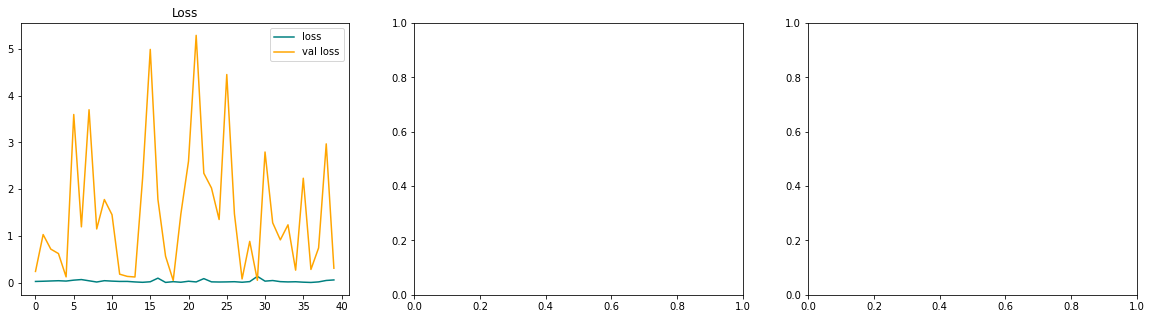

In [84]:
fig,ax = plt.subplots(ncols = 3, figsize = (20,5))

ax[0].plot(hist.history['total_loss'],color = 'teal',label = 'loss')
ax[0].plot(hist.history['val_total_loss'],color = 'orange',label = 'val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

In [88]:
model.load_weights(checkpoint_filepath)

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
handtracker.save('handtrackerInception.h5')

In [ ]:
handtracker = load_model('handtracker.h5')

In [110]:
test_data = val.as_numpy_iterator()

In [111]:
test_sample = test_data.next()

In [112]:
yhat = model.predict(test_sample[0])

In [101]:
yhat[1].shape

(8, 2, 4)

In [92]:
test_sample[0].shape

(8, 120, 120, 3)

In [95]:
yhat[0][0]

array([0.9999999 , 0.01513953], dtype=float32)

In [96]:
yhat[1][0]

array([[0.45661095, 0.5339128 , 0.1448086 , 0.36738864],
       [0.01647889, 0.05185114, 0.0092953 , 0.01479188]], dtype=float32)

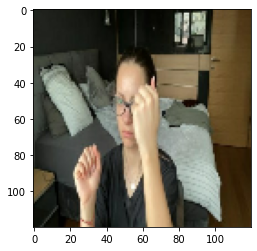

In [97]:
sample_image = test_sample[0][0]
plt.imshow(sample_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ValueError: Top-left axes cannot be negative. To silently skip out of bounds cases pass 'strict=False'.

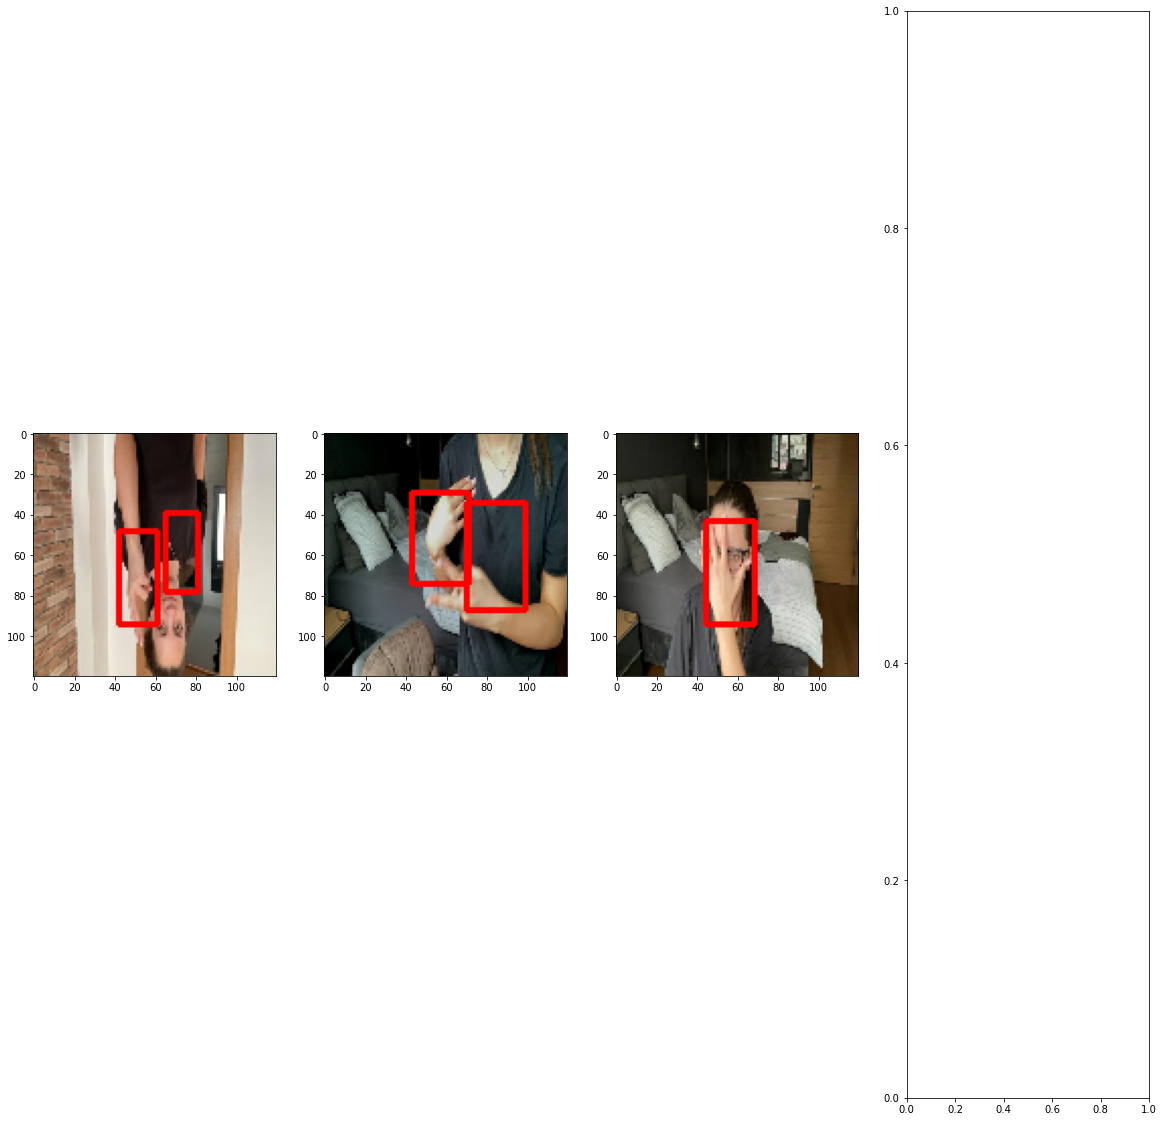

In [113]:
fig,ax = plt.subplots(ncols = 4,figsize=(20,20))
for idx in range(4):
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    
    if yhat[0][idx][0]>0.5:
        coords1 = sample_coords[0].copy()
        for i in range(len(coords1)):
            coords1[i] = float(sample_coords[0][i])    
        coords1 = tuple(coords1) 
        coords1 =  yolo_cords_to_voc(coords1,sample_image.shape[0],sample_image.shape[1])
        
        cv2.rectangle(sample_image,coords1[:2],coords1[2:],
              (255,0,0),2)
    if yhat[0][idx][1]>0.5:
        coords2 = sample_coords[1].copy()
        for i in range(len(coords2)):
            coords2[i] = float(sample_coords[1][i])

        coords2 = tuple(coords2)
        
        coords2 =  yolo_cords_to_voc(coords2,120,120)
        
        cv2.rectangle(sample_image,coords2[:2],coords2[2:],
              (255,0,0),2)
    
    
    ax[idx].imshow(sample_image)

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _, frame = cap.read()
    frame = frame[50:500,50:500,:]
    
    rgb = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb,(120,120))
    
    yhat = handtracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0][0][0]>0.5:
        coords1 = sample_coords[0].copy()
        for i in range(len(coords)):
            coords1[i] = float(sample_coords[0][i])    
        coords1 = tuple(coords1) 
        coords1 =  yolo_cords_to_voc(coords1,sample_image.shape[0],sample_image.shape[1])
        
        cv2.rectangle(frame,coords1[:2],coords1[2:],
              (255,0,0),2)
    if yhat[0][0][1]>0.5:
        coords2 = sample_coords[1].copy()
        for i in range(len(coords2)):
            coords2[i] = float(sample_coords[1][i])

        coords2 = tuple(coords2)
        
        coords2 =  yolo_cords_to_voc(coords2,120,120)
        
        cv2.rectangle(frame,coords2[:2],coords2[2:],
              (255,0,0),2)
        
    cv2.imshow('HandTrack',frame)
    
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()
    
    